#**Loan Application on Banking**
The director of SZE bank identified that going through the loan applications to filter the people who can be granted loans or need to be rejected is a tedious and time-consuming process. He wants to automate it and increase his bank’s efficiency. So in this project, I want to make ML model to predict whether the application will accepted or rejected based on their data (history).

Mohamad Irwan Afandi - Data Scientist Enthusiastic
__________

The list of content on this notebook:

**Import Library and Load Dataset**
- Import library is needed
- Load the dataset (train and test)

**Data Preparation**
- Brief information from dataset such as null values and data types
- Take care the null values

**Exploratory Data Analysis**
- Perform descriptive statistic between categorical and numerical variable
- Perform correlation

**Data pre-processing**
- Drop any duplicate values
- Perform one-hot encoding

**Modelling**
- LogisticRegression
- Random Forest
- Decision Tree
- Gradient Boosting
- XGBoost


#**Import Library and Load Dataset**

In [ ]:
#import common library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

#import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, make_scorer, classification_report

#import for output library
import pickle
import json
from google.colab import files

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_train.csv" )
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_test.csv')
df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP002305,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,1,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,2,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,3,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,4,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


#**Data Preparation**

##Explore the Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         491 non-null    int64  
 1   Loan_ID            491 non-null    object 
 2   Gender             481 non-null    object 
 3   Married            490 non-null    object 
 4   Dependents         482 non-null    object 
 5   Education          491 non-null    object 
 6   Self_Employed      462 non-null    object 
 7   ApplicantIncome    491 non-null    int64  
 8   CoapplicantIncome  491 non-null    float64
 9   LoanAmount         475 non-null    float64
 10  Loan_Amount_Term   478 non-null    float64
 11  Credit_History     448 non-null    float64
 12  Property_Area      491 non-null    object 
 13  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 53.8+ KB


There are 14 columns with 1 unnamed variable, from that info we can also see some missing values in that data.

In [ ]:
df.describe()

,Unnamed: 0,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,491.000000,491.000000,491.000000,475.000000,478.000000,448.000000,491.000000
mean,245.000000,5401.189409,1589.730998,145.014737,341.297071,0.848214,0.698574
std,141.883755,6419.427177,2919.320624,86.310534,66.964051,0.359214,0.459345
min,0.000000,150.000000,0.000000,17.000000,12.000000,0.000000,0.000000
25%,122.500000,2923.500000,0.000000,100.000000,360.000000,1.000000,0.000000
50%,245.000000,3865.000000,1229.000000,126.000000,360.000000,1.000000,1.000000
75%,367.500000,5705.500000,2251.500000,162.000000,360.000000,1.000000,1.000000
max,490.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,1.000000


There are some missing value in this data like : CoapplicantIncome, LoanAmount, and ApplicantIncome. We can see the different between mean and max value

In [ ]:
df.select_dtypes(include='object').columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')

In [ ]:
df.select_dtypes(include='number').columns

Index(['Unnamed: 0', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')

From this data I think we can drop Unnamed: 0, and Loan ID becase it isn't important

In [ ]:
df = df.drop(['Unnamed: 0', 'Loan_ID'], axis=1)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


In [ ]:
def get_null_value_report(df):
  null_val = pd.DataFrame(df.dtypes).T.rename(index = {0:'Columns Type'})
  null_val = null_val.append(pd.DataFrame(df.isnull().sum()).T.rename(index = {0:'Null Value'}))
  null_val = null_val.append(pd.DataFrame(round(df.isnull().sum()/df.shape[0]*100,2)).T.rename(index = {0:'Percentage'}))
  return null_val
  
get_null_value_report(df).head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Columns Type,object,object,object,object,object,int64,float64,float64,float64,float64,object,int64
Null Value,10,1,9,0,29,0,0,16,13,43,0,0
Percentage,2.04,0.2,1.83,0,5.91,0,0,3.26,2.65,8.76,0,0


Baseds on the result obove, there are 7 columns with missing value but the missing value percentage not more than 10% (minor missing value). We can fill missing value with median(numerical), mode(categorical), or analysis aproach from the data.

## Missing Value Handling

In [ ]:
#inputation in categorical data
for col in df.select_dtypes(include='object').columns:
  df[col] = df[col].fillna(df[col].mode()[0])

#inputation in numerical data
for col in df.select_dtypes(include='number').columns:
  df[col] = df[col].fillna(df[col].median())

get_null_value_report(df).head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Columns Type,object,object,object,object,object,int64,float64,float64,float64,float64,object,int64
Null Value,0,0,0,0,0,0,0,0,0,0,0,0
Percentage,0,0,0,0,0,0,0,0,0,0,0,0


#**Exploratory Data Analysis**

## Numeric Variable

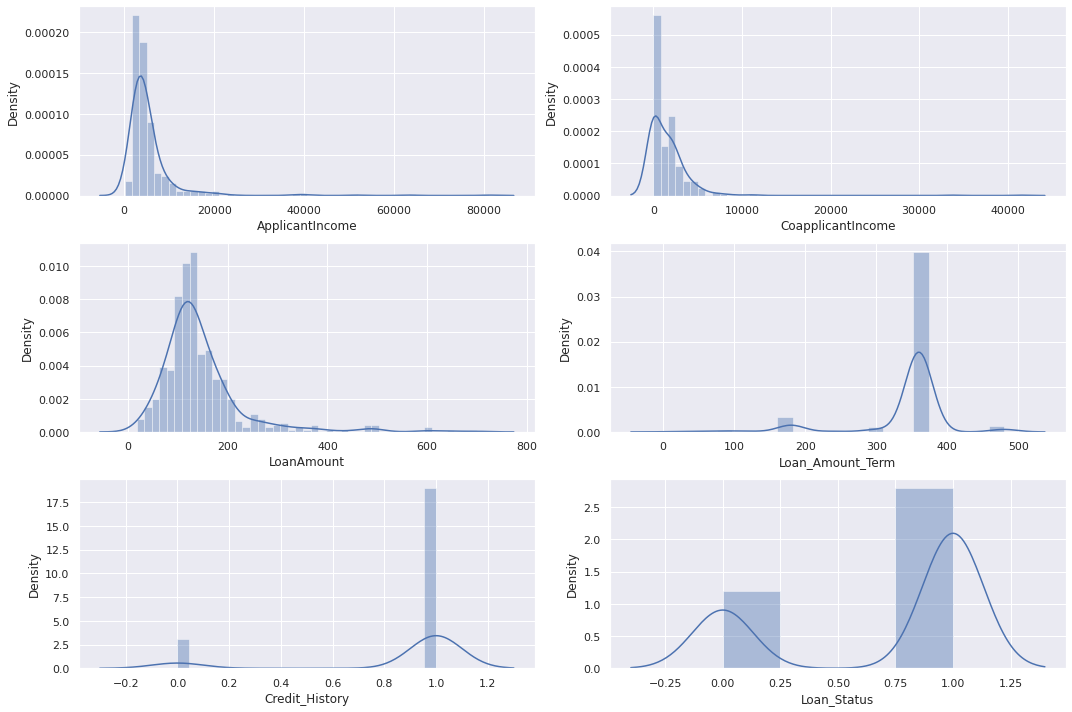

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(15,10))
axes = [col for rows in axes for col in rows]

for index, col in enumerate(df.select_dtypes(include='number').columns):
  plot =sns.distplot(df[col], ax=axes[index])
plt.tight_layout()

## Categorical Variable

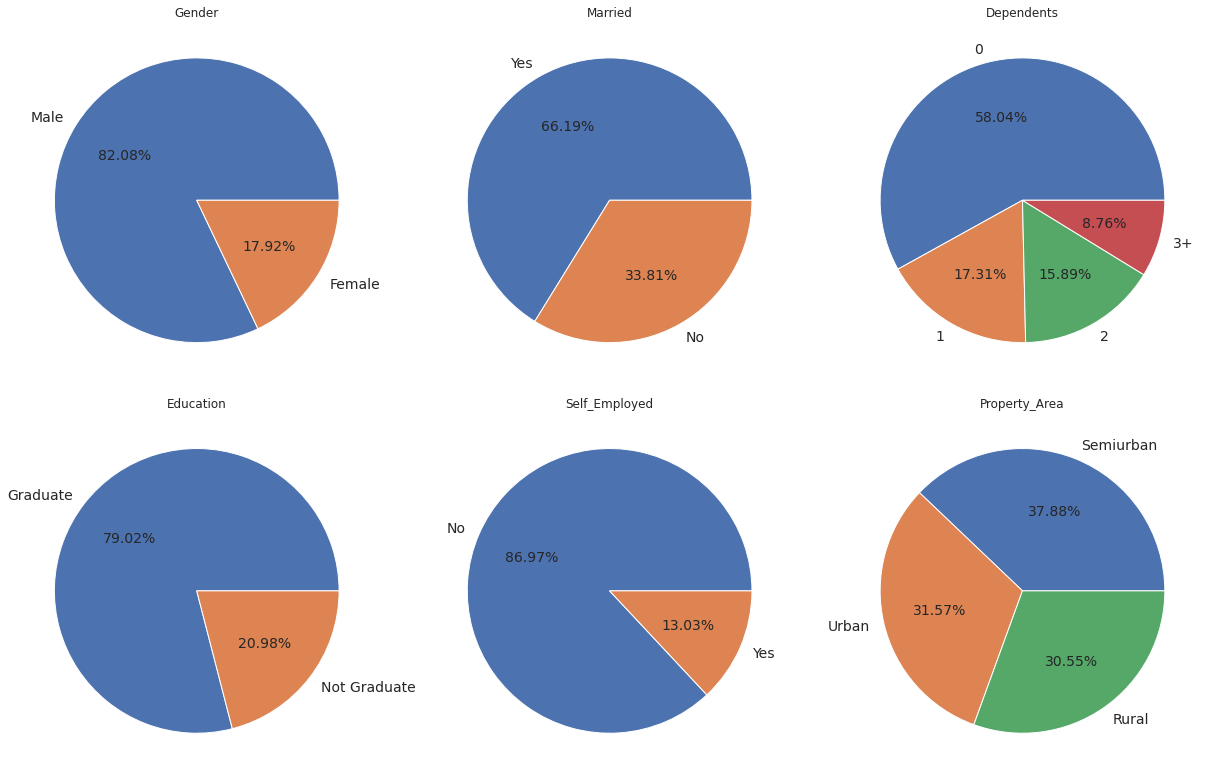

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(17,11))
axes = [col for rows in axes for col in rows]

for index, col in enumerate(df.select_dtypes(include='object').columns):
  plot = df[col].value_counts().plot(kind='pie', title=col, autopct='%1.2f%%', fontsize=14, ax=axes[index])
  plot = axes[index].set_ylabel('')
plt.tight_layout()

# df.loc[df.Loan_Status==1, 'Gender'].value_counts().plot(kind='pie', title='Gender 1', autopct='%1.2f%%', fontsize=14)
# df.loc[df.Loan_Status==0, 'Gender'].value_counts().plot(kind='pie', title='Gender 1', autopct='%1.2f%%', fontsize=14)

Baseds on the visualization above, at least we know the proportion and distribution of the data. So we can use this info for in preprocessing steps.

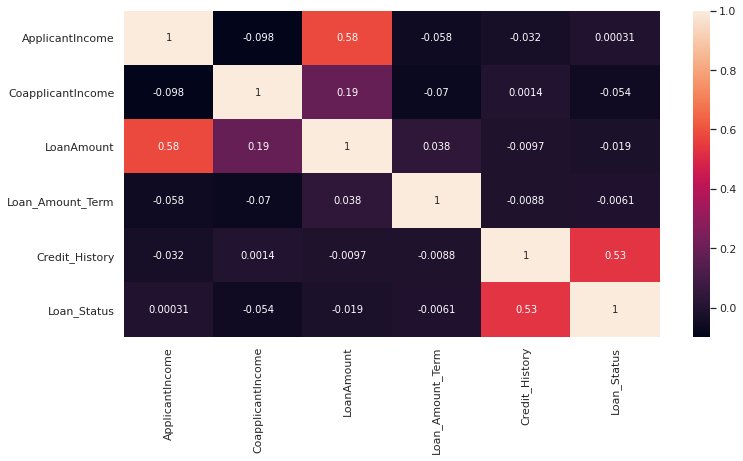

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

See the correlation performace above, the most impactfull features to determine whether a loan application acceted or rejected are LoanAmount(58%) and Credit_History (53%).

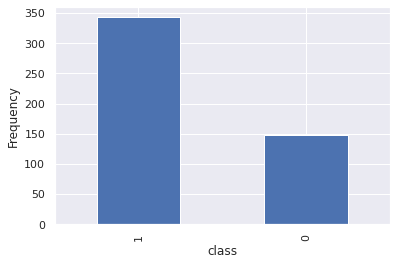

In [ ]:
df.Loan_Status.value_counts().plot(kind='bar')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

This data is imbalance dataset

#**Preprocessing**

## Drop Duplicate

In [ ]:
print("before droping the duplicate value: ", df.shape[0])
df = df.drop_duplicates()
print("after droping the duplicate value: ", df.shape[0])

before droping the duplicate value:  491
after droping the duplicate value:  491


There isn't duplicate value

## One Hot Encoding

In [ ]:
#without drop first
df_dumm = pd.get_dummies(df)
df_dumm.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,4547,0.0,115.0,360.0,1.0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0
1,5703,0.0,130.0,360.0,1.0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0
2,4333,2451.0,110.0,360.0,1.0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,1
3,4695,0.0,96.0,360.0,1.0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1
4,6700,1750.0,230.0,300.0,1.0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0


In [ ]:
#with drop first
df_dumm_drop = pd.get_dummies(df, drop_first=True)
df_dumm_drop.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,4547,0.0,115.0,360.0,1.0,1,0,0,0,0,0,0,0,1,0
1,5703,0.0,130.0,360.0,1.0,1,1,1,0,0,1,1,1,0,0
2,4333,2451.0,110.0,360.0,1.0,0,0,1,0,0,0,0,0,0,1
3,4695,0.0,96.0,360.0,1.0,1,1,1,0,0,0,1,1,0,1
4,6700,1750.0,230.0,300.0,1.0,1,1,1,0,1,0,0,0,1,0


## Train Test Split

In [ ]:
#without drop first
X = df_dumm.drop('Loan_Status', axis=1)
y = df_dumm.Loan_Status
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [ ]:
#wit drop first
X = df_dumm_drop.drop('Loan_Status', axis=1)
y = df_dumm_drop.Loan_Status
x_train_drop, x_test_drop, y_train_drop, y_test_drop = train_test_split(X, y, test_size=0.25, random_state=123)

## Power Transformer

In [ ]:
#without drop first
pt = PowerTransformer()
x_train_pt = pd.DataFrame(pt.fit_transform(x_train), columns=x_train.columns)
x_test_pt = pd.DataFrame(pt.transform(x_test), columns=x_train.columns)

In [ ]:
#wit drop first
pt_d = PowerTransformer()
x_train_pt_drop = pd.DataFrame(pt_d.fit_transform(x_train_drop), columns=x_train_drop.columns)
x_test_pt_drop = pd.DataFrame(pt_d.transform(x_test_drop), columns=x_train_drop.columns)

##Standardization

In [ ]:
#without drop first
scale = StandardScaler()
xtrain_scale = pd.DataFrame(scale.fit_transform(x_train_pt), columns=x_train_pt.columns)
xtest_scale = pd.DataFrame(scale.fit_transform(x_test_pt), columns=x_train_pt.columns)

In [ ]:
#with drop first
scale_d = StandardScaler()
xtrain_scale_drop = pd.DataFrame(scale_d.fit_transform(x_train_pt_drop), columns=x_train_pt_drop.columns)
xtest_scale_drop = pd.DataFrame(scale_d.fit_transform(x_test_pt_drop), columns=x_train_pt_drop.columns)

## Imbalance Handling

In [ ]:
# sm = SMOTE(random_state = 25, sampling_strategy = 1.0)
# x_train, y_train = sm.fit_sample(x_train, y_train)
# sns.countplot(y_train)
# plt.show()

#**Modelling**

In [ ]:
class Class(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold, n_jobs=-1, verbose= 2)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict_test(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Testing Accuracy: {:.2f}%".format(100*accuracy_score(Y, self.predictions)))
        print("Testing F1-score: {:.2f}%".format(100*f1_score(Y, self.predictions)))
        print()
        print(classification_report(Y, self.predictions))
        
        
    def grid_predict_train(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Training Accuracy: {:.2f}%".format(100*accuracy_score(Y, self.predictions)))

## Logistic Regression

In [ ]:
#one hot encoding
lr = Class(clf = LogisticRegression)
params = {'C': np.logspace(-2, 2, 6),
          'penalty':['l1', 'l2', 'elasticnet'],
          'max_iter': [50*x for x in range(1,6)]}
lr.grid_search(parameters = params, Kfold = 5)
lr.grid_fit(x_train, y_train)
lr.grid_predict_train(x_train, y_train)
lr.grid_predict_test(x_test, y_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:    2.9s


Training Accuracy: 80.16%
Testing Accuracy: 82.93%

              precision    recall  f1-score   support

           0       0.85      0.49      0.62        35
           1       0.83      0.97      0.89        88

    accuracy                           0.83       123
   macro avg       0.84      0.73      0.75       123
weighted avg       0.83      0.83      0.81       123



[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    5.7s finished


In [ ]:
#one hot encoding drop
lr = Class(clf = LogisticRegression)
params = {'C': np.logspace(-2, 2, 6),
          'penalty':['l1', 'l2', 'elasticnet'],
          'max_iter': [50*x for x in range(1,6)]}
lr.grid_search(parameters = params, Kfold = 5)
lr.grid_fit(x_train_drop, y_train_drop)
lr.grid_predict_train(x_train_drop, y_train_drop)
lr.grid_predict_test(x_test_drop, y_test_drop)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    3.2s


Training Accuracy: 80.98%
Testing Accuracy: 83.74%
Testing F1-score: 89.58%

              precision    recall  f1-score   support

           0       0.89      0.49      0.63        35
           1       0.83      0.98      0.90        88

    accuracy                           0.84       123
   macro avg       0.86      0.73      0.76       123
weighted avg       0.85      0.84      0.82       123



[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    3.6s finished


In [ ]:
#one hot encoding -transform & scale
lr = Class(clf = LogisticRegression)
params = {'C': np.logspace(-2, 2, 6),
          'penalty':['l1', 'l2', 'elasticnet'],
          'max_iter': [50*x for x in range(1,6)]}
lr.grid_search(parameters = params, Kfold = 5)
lr.grid_fit(xtrain_scale, y_train)
lr.grid_predict_train(xtrain_scale, y_train)
lr.grid_predict_test(xtest_scale, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Training Accuracy: 80.43%
Testing Accuracy: 82.93%

              precision    recall  f1-score   support

           0       0.89      0.46      0.60        35
           1       0.82      0.98      0.89        88

    accuracy                           0.83       123
   macro avg       0.85      0.72      0.75       123
weighted avg       0.84      0.83      0.81       123



[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.5s finished


In [ ]:
#one hot encoding drop -transform & scale
lr = Class(clf = LogisticRegression)
params = {'C': np.logspace(-2, 2, 6),
          'penalty':['l1', 'l2', 'elasticnet'],
          'max_iter': [50*x for x in range(1,6)]}
lr.grid_search(parameters = params, Kfold = 5)
lr.grid_fit(xtrain_scale_drop, y_train_drop)
lr.grid_predict_train(xtrain_scale_drop, y_train_drop)
lr.grid_predict_test(xtest_scale_drop, y_test_drop)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Training Accuracy: 80.71%
Testing Accuracy: 82.93%

              precision    recall  f1-score   support

           0       0.89      0.46      0.60        35
           1       0.82      0.98      0.89        88

    accuracy                           0.83       123
   macro avg       0.85      0.72      0.75       123
weighted avg       0.84      0.83      0.81       123



[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.4s finished


## SVM

In [ ]:
#one hot encoding
svm = Class(clf = SVC)
params = {'C': [0.001, 0.1, 1],
          'kernel':['linear', 'rbf'],
          'class_weight':['None', 'dict', 'balanced']}
svm.grid_search(parameters = params, Kfold = 5)
svm.grid_fit(x_train, y_train)
svm.grid_predict_train(x_train, y_train)
svm.grid_predict_test(x_test, y_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 14.8min finished


Training Accuracy: 72.83%
Testing Accuracy: 62.60%

              precision    recall  f1-score   support

           0       0.39      0.54      0.45        35
           1       0.78      0.66      0.72        88

    accuracy                           0.63       123
   macro avg       0.59      0.60      0.58       123
weighted avg       0.67      0.63      0.64       123



In [ ]:
#one hot encoding drop
svm = Class(clf = SVC)
params = {'C': [0.001, 0.1, 1],
          'kernel':['linear', 'rbf'],
          'class_weight':['None', 'dict', 'balanced']}
svm.grid_search(parameters = params, Kfold = 5)
svm.grid_fit(x_train_drop, y_train_drop)
svm.grid_predict_train(x_train_drop, y_train_drop)
svm.grid_predict_test(x_test_drop, y_test_drop)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 15.1min finished


Training Accuracy: 73.64%
Testing Accuracy: 65.04%

              precision    recall  f1-score   support

           0       0.40      0.49      0.44        35
           1       0.78      0.72      0.75        88

    accuracy                           0.65       123
   macro avg       0.59      0.60      0.59       123
weighted avg       0.67      0.65      0.66       123



In [ ]:
#one hot encoding drop -transform & scale
svm = Class(clf = SVC)
params = {'C': [0.001, 0.1, 1],
          'kernel':['linear', 'rbf'],
          'class_weight':['None', 'dict', 'balanced']}
svm.grid_search(parameters = params, Kfold = 5)
svm.grid_fit(xtrain_scale_drop, y_train_drop)
svm.grid_predict_train(xtrain_scale_drop, y_train_drop)
svm.grid_predict_test(xtest_scale_drop, y_test_drop)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training Accuracy: 81.52%
Testing Accuracy: 82.11%
Testing F1-score: 88.54%

              precision    recall  f1-score   support

           0       0.84      0.46      0.59        35
           1       0.82      0.97      0.89        88

    accuracy                           0.82       123
   macro avg       0.83      0.71      0.74       123
weighted avg       0.82      0.82      0.80       123



[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.5s finished


## KNN

In [ ]:
#one hot encoding
knn = Class(clf = KNeighborsClassifier)
params = {'n_neighbors': np.arange(5,25,5),
          'leaf_size':np.arange(25,50,5),
          'p':[1,2]} #1: manhattan , 2:euclidian

knn.grid_search(parameters = params, Kfold = 5)
knn.grid_fit(x_train, y_train)
knn.grid_predict_train(x_train, y_train)
knn.grid_predict_test(x_test, y_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training Accuracy: 70.38%
Testing Accuracy: 73.17%

              precision    recall  f1-score   support

           0       0.75      0.09      0.15        35
           1       0.73      0.99      0.84        88

    accuracy                           0.73       123
   macro avg       0.74      0.54      0.50       123
weighted avg       0.74      0.73      0.65       123



[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.5s finished


In [ ]:
#one hot encoding drop
knn = Class(clf = KNeighborsClassifier)
params = {'n_neighbors': np.arange(5,25,5),
          'leaf_size':np.arange(25,50,5),
          'p':[1,2]} #1: manhattan , 2:euclidian

knn.grid_search(parameters = params, Kfold = 5)
knn.grid_fit(x_train_drop, y_train_drop)
knn.grid_predict_train(x_train_drop, y_train_drop)
knn.grid_predict_test(x_test_drop, y_test_drop)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Training Accuracy: 70.38%
Testing Accuracy: 73.17%

              precision    recall  f1-score   support

           0       0.75      0.09      0.15        35
           1       0.73      0.99      0.84        88

    accuracy                           0.73       123
   macro avg       0.74      0.54      0.50       123
weighted avg       0.74      0.73      0.65       123



[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished


In [ ]:
#one hot encoding drop -transform & scale
knn = Class(clf = KNeighborsClassifier)
params = {'n_neighbors': np.arange(5,25,5),
          'leaf_size':np.arange(25,50,5),
          'p':[1,2]} #1: manhattan , 2:euclidian

knn.grid_search(parameters = params, Kfold = 5)
knn.grid_fit(xtrain_scale_drop, y_train_drop)
knn.grid_predict_train(xtrain_scale_drop, y_train_drop)
knn.grid_predict_test(xtest_scale_drop, y_test_drop)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training Accuracy: 80.16%
Testing Accuracy: 82.93%
Testing F1-score: 88.65%

              precision    recall  f1-score   support

           0       0.77      0.57      0.66        35
           1       0.85      0.93      0.89        88

    accuracy                           0.83       123
   macro avg       0.81      0.75      0.77       123
weighted avg       0.82      0.83      0.82       123



[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished


## Random Forest

In [ ]:
#one hot encoding
rf = Class(clf = RandomForestClassifier)
params = {'min_samples_leaf': [2, 3, 4, 5],
          'min_samples_split':[2,3,4],
          'n_estimators': np.arange(80,300,20),
          'criterion': ['entropy','gini'],
          'max_features': ["auto", "sqrt", "log2"]}
rf.grid_search(parameters = params, Kfold = 5)
rf.grid_fit(x_train, y_train)
rf.grid_predict_train(x_train, y_train)
rf.grid_predict_test(x_test, y_test)

Fitting 5 folds for each of 792 candidates, totalling 3960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 3960 out of 3960 | elapsed: 15.4min finished


Training Accuracy: 81.79%
Testing Accuracy: 82.93%
Testing F1-score: 89.12%

              precision    recall  f1-score   support

           0       0.89      0.46      0.60        35
           1       0.82      0.98      0.89        88

    accuracy                           0.83       123
   macro avg       0.85      0.72      0.75       123
weighted avg       0.84      0.83      0.81       123



In [ ]:
#one hot encoding drop
rf = Class(clf = RandomForestClassifier)
params = {'min_samples_leaf': [2, 3, 4, 5],
          'min_samples_split':[2,3,4],
          'n_estimators': np.arange(80,300,20),
          'criterion': ['entropy','gini'],
          'max_features': ["auto", "sqrt", "log2"]}
rf.grid_search(parameters = params, Kfold = 5)
rf.grid_fit(x_train_drop, y_train_drop)
rf.grid_predict_train(x_train_drop, y_train_drop)
rf.grid_predict_test(x_test_drop, y_test_drop)

Fitting 5 folds for each of 792 candidates, totalling 3960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 3960 out of 3960 | elapsed: 15.3min finished


Training Accuracy: 90.76%
Testing Accuracy: 82.93%

              precision    recall  f1-score   support

           0       0.85      0.49      0.62        35
           1       0.83      0.97      0.89        88

    accuracy                           0.83       123
   macro avg       0.84      0.73      0.75       123
weighted avg       0.83      0.83      0.81       123



In [ ]:
#one hot encoding drop -transform & scale
rf = Class(clf = RandomForestClassifier)
params = {'min_samples_leaf': [2, 3, 4, 5],
          'min_samples_split':[2,3,4],
          'n_estimators': np.arange(80,300,20),
          'criterion': ['entropy','gini'],
          'max_features': ["auto", "sqrt", "log2"]}
rf.grid_search(parameters = params, Kfold = 5)
rf.grid_fit(xtrain_scale_drop, y_train_drop)
rf.grid_predict_train(xtrain_scale_drop, y_train_drop)
rf.grid_predict_test(xtest_scale_drop, y_test_drop)

Fitting 5 folds for each of 792 candidates, totalling 3960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 3960 out of 3960 | elapsed: 15.3min finished


Training Accuracy: 82.07%
Testing Accuracy: 82.93%
Testing F1-score: 89.12%

              precision    recall  f1-score   support

           0       0.89      0.46      0.60        35
           1       0.82      0.98      0.89        88

    accuracy                           0.83       123
   macro avg       0.85      0.72      0.75       123
weighted avg       0.84      0.83      0.81       123



## Decision Tree

In [ ]:
#one hot encoding
dt = Class(clf = DecisionTreeClassifier)
params = {'min_samples_leaf': [1, 2, 3, 4, 5],
          'min_samples_split':[2,3,4,5],
          'criterion': ['entropy','gini'],
          'max_features': ["auto", "sqrt", "log2"]}
dt.grid_search(parameters = params, Kfold = 5)
dt.grid_fit(x_train, y_train)
dt.grid_predict_train(x_train, y_train)
dt.grid_predict_test(x_test, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training Accuracy: 83.15%
Testing Accuracy: 74.80%
Testing F1-score: 82.87%

              precision    recall  f1-score   support

           0       0.57      0.49      0.52        35
           1       0.81      0.85      0.83        88

    accuracy                           0.75       123
   macro avg       0.69      0.67      0.68       123
weighted avg       0.74      0.75      0.74       123



[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.0s finished


In [ ]:
#one hot encoding drop
dt = Class(clf = DecisionTreeClassifier)
params = {'min_samples_leaf': [1, 2, 3, 4, 5],
          'min_samples_split':[2,3,4,5],
          'criterion': ['entropy','gini'],
          'max_features': ["auto", "sqrt", "log2"]}
dt.grid_search(parameters = params, Kfold = 5)
dt.grid_fit(x_train_drop, y_train_drop)
dt.grid_predict_train(x_train_drop, y_train_drop)
dt.grid_predict_test(x_test_drop, y_test_drop)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:    1.6s


Training Accuracy: 86.14%
Testing Accuracy: 78.05%
Testing F1-score: 84.75%

              precision    recall  f1-score   support

           0       0.62      0.60      0.61        35
           1       0.84      0.85      0.85        88

    accuracy                           0.78       123
   macro avg       0.73      0.73      0.73       123
weighted avg       0.78      0.78      0.78       123



[Parallel(n_jobs=-1)]: Done 597 out of 600 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.0s finished


In [ ]:
#one hot encoding drop -transform & scale
dt = Class(clf = DecisionTreeClassifier)
params = {'min_samples_leaf': [1, 2, 3, 4, 5],
          'min_samples_split':[2,3,4,5],
          'criterion': ['entropy','gini'],
          'max_features': ["auto", "sqrt", "log2"]}
dt.grid_search(parameters = params, Kfold = 5)
dt.grid_fit(xtrain_scale_drop, y_train_drop)
dt.grid_predict_train(xtrain_scale_drop, y_train_drop)
dt.grid_predict_test(xtest_scale_drop, y_test_drop)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training Accuracy: 85.60%
Testing Accuracy: 69.11%
Testing F1-score: 77.38%

              precision    recall  f1-score   support

           0       0.47      0.57      0.51        35
           1       0.81      0.74      0.77        88

    accuracy                           0.69       123
   macro avg       0.64      0.66      0.64       123
weighted avg       0.71      0.69      0.70       123



[Parallel(n_jobs=-1)]: Done 575 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.8s finished


## Gradient Boosting

In [ ]:
#one hot encoding
gb = Class(clf = GradientBoostingClassifier)
params = {'n_estimators': np.arange(90,300,30),
          'loss': ['deviance', 'exponential'],
          'learning_rate': [0.01, 0.1, 1, 5],
          'criterion': ['friedman_mse', 'mse', 'mae']}
gb.grid_search(parameters = params, Kfold = 5)
gb.grid_fit(x_train, y_train)
gb.grid_predict_train(x_train, y_train)
gb.grid_predict_test(x_test, y_test)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  4.9min finished


Training Accuracy: 81.79%
Testing Accuracy: 83.74%
Testing F1-score: 89.58%

              precision    recall  f1-score   support

           0       0.89      0.49      0.63        35
           1       0.83      0.98      0.90        88

    accuracy                           0.84       123
   macro avg       0.86      0.73      0.76       123
weighted avg       0.85      0.84      0.82       123



In [ ]:
#one hot encoding drop
gb = Class(clf = GradientBoostingClassifier)
params = {'n_estimators': np.arange(90,300,30),
          'loss': ['deviance', 'exponential'],
          'learning_rate': [0.01, 0.1, 1, 5],
          'criterion': ['friedman_mse', 'mse', 'mae']}
gb.grid_search(parameters = params, Kfold = 5)
gb.grid_fit(x_train_drop, y_train_drop)
gb.grid_predict_train(x_train_drop, y_train_drop)
gb.grid_predict_test(x_test_drop, y_test_drop)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 647 tasks      | elapsed:  2.1min


Training Accuracy: 81.25%
Testing Accuracy: 81.30%
Testing F1-score: 88.21%

              precision    recall  f1-score   support

           0       0.88      0.40      0.55        35
           1       0.80      0.98      0.88        88

    accuracy                           0.81       123
   macro avg       0.84      0.69      0.72       123
weighted avg       0.82      0.81      0.79       123



[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  4.2min finished


In [ ]:
#one hot encoding drop -transform & scale
gb = Class(clf = GradientBoostingClassifier)
params = {'n_estimators': np.arange(90,300,30),
          'loss': ['deviance', 'exponential'],
          'learning_rate': [0.01, 0.1, 1, 5],
          'criterion': ['friedman_mse', 'mse', 'mae']}
gb.grid_search(parameters = params, Kfold = 5)
gb.grid_fit(xtrain_scale_drop, y_train_drop)
gb.grid_predict_train(xtrain_scale_drop, y_train_drop)
gb.grid_predict_test(xtest_scale_drop, y_test_drop)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 647 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  4.1min finished


Training Accuracy: 82.07%
Testing Accuracy: 80.49%
Testing F1-score: 87.76%

              precision    recall  f1-score   support

           0       0.87      0.37      0.52        35
           1       0.80      0.98      0.88        88

    accuracy                           0.80       123
   macro avg       0.83      0.67      0.70       123
weighted avg       0.82      0.80      0.78       123



## XGBoost

In [ ]:
#one hot encoding
xgb = Class(clf = XGBClassifier)
params = {'n_estimators': np.arange(100,500,100),
          'loss': ['deviance', 'exponential'],
          'eta': [0.01, 0.1, 1, 5],
          'min_child_weight':[1, 2, 3],
          'max_depth': [5,6,7]}

xgb.grid_search(parameters = params, Kfold = 5)
xgb.grid_fit(x_train, y_train)
xgb.grid_predict_train(x_train, y_train)
xgb.grid_predict_test(x_test, y_test)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  1.7min


Training Accuracy: 91.58%
Testing Accuracy: 78.86%
Testing F1-score: 85.71%

              precision    recall  f1-score   support

           0       0.66      0.54      0.59        35
           1       0.83      0.89      0.86        88

    accuracy                           0.79       123
   macro avg       0.74      0.71      0.73       123
weighted avg       0.78      0.79      0.78       123



[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.5min finished


In [ ]:
#one hot encoding drop
xgb = Class(clf = XGBClassifier)
params = {'n_estimators': np.arange(100,500,100),
          'loss': ['deviance', 'exponential'],
          'eta': [0.01, 0.1, 1, 5],
          'min_child_weight':[1, 2, 3],
          'max_depth': [5,6,7]}
xgb.grid_search(parameters = params, Kfold = 5)
xgb.grid_fit(x_train_drop, y_train_drop)
xgb.grid_predict_train(x_train_drop, y_train_drop)
xgb.grid_predict_test(x_test_drop, y_test_drop)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:  1.8min


Training Accuracy: 95.11%
Testing Accuracy: 81.30%
Testing F1-score: 87.83%

              precision    recall  f1-score   support

           0       0.77      0.49      0.60        35
           1       0.82      0.94      0.88        88

    accuracy                           0.81       123
   macro avg       0.80      0.71      0.74       123
weighted avg       0.81      0.81      0.80       123



[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.1min finished


In [ ]:
#one hot encoding drop -transform & scale
xgb = Class(clf = XGBClassifier)
params = {'n_estimators': np.arange(100,500,100),
          'loss': ['deviance', 'exponential'],
          'eta': [0.01, 0.1, 1, 5],
          'min_child_weight':[1, 2, 3],
          'max_depth': [5,6,7]}
xgb.grid_search(parameters = params, Kfold = 5)
xgb.grid_fit(xtrain_scale_drop, y_train_drop)
xgb.grid_predict_train(xtrain_scale_drop, y_train_drop)
xgb.grid_predict_test(xtest_scale_drop, y_test_drop)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:  1.8min


Training Accuracy: 95.11%
Testing Accuracy: 81.30%
Testing F1-score: 87.96%

              precision    recall  f1-score   support

           0       0.80      0.46      0.58        35
           1       0.82      0.95      0.88        88

    accuracy                           0.81       123
   macro avg       0.81      0.71      0.73       123
weighted avg       0.81      0.81      0.79       123



[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.1min finished


<b>Modelling Summarizatoin</b>
- I used 7 classifiers to buld the model where every classifier has 3 combination (ohe : one hot encoding, ohe_dp : one hot encoding drop first, ohe_dp_tfsc : one hot encoding drop first transform and scaling). So we have 21 results from this modelling step.
- Three models are overfitting i.e XGBoost(all), Decission Tree(all), and RF (ohe_dp)
- Some of models have low accuracy score like SVM(ohe, ohe_dp) and knn(ohe, ohe_drop)
- So we only have 10 good model, to select which is the best. We can see from the accuracy score and also its f1-score. I choose 3 best model : LR ohe (T(train): 80.98% Tt(Test): 83.74% F1: 89.58%), RF ohe_dp_tfsc (T: 82.07% Tt: 82.93% F1: 89.12%) and GB ohe (T: 81.79% Tt: 83.74% F1: 89.58%)

#**Predict Data Test**

In [ ]:
#check missing value 
get_null_value_report(test_data)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Columns Type,object,object,object,object,object,object,int64,float64,float64,float64,float64,object
Null Value,0,3,2,6,0,3,0,0,6,1,7,0
Percentage,0,2.44,1.63,4.88,0,2.44,0,0,4.88,0.81,5.69,0


In [ ]:
#missing value handling

#inputation in categorical data
for col in test_data.select_dtypes(include='object').columns:
  test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

#inputation in numerical data
for col in test_data.select_dtypes(include='number').columns:
  test_data[col] = test_data[col].fillna(test_data[col].median())

get_null_value_report(test_data)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Columns Type,object,object,object,object,object,object,int64,float64,float64,float64,float64,object
Null Value,0,0,0,0,0,0,0,0,0,0,0,0
Percentage,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#drop column
test_data = test_data.drop(['Loan_ID'], axis=1)

#without drop first
test_data1 = pd.get_dummies(test_data)

#with drop first
test_data2 = pd.get_dummies(test_data, drop_first=True)
test_data2.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,3748,1668.0,110.0,360.0,1.0,1,0,0,0,0,1,0,1,0
1,4000,7750.0,290.0,360.0,1.0,1,1,0,0,1,0,0,1,0
2,2625,6250.0,187.0,360.0,1.0,1,1,0,0,0,0,0,0,0
3,3902,1666.0,109.0,360.0,1.0,1,0,0,0,0,1,0,0,0
4,6096,0.0,218.0,360.0,0.0,1,1,0,0,0,1,0,0,0


In [ ]:
#transform
test_data2 = pd.DataFrame(pt.transform(test_data2), columns=test_data2.columns)

#scaling
test_data2 = pd.DataFrame(scale.transform(test_data2), columns=test_data2.columns)

#**Export to File**

In [ ]:
#LR ohe (Best based on submission - 87.15)
params = {'C': np.logspace(-2, 2, 6),
          'penalty':['l1', 'l2', 'elasticnet'],
          'max_iter': [50*x for x in range(1,6)]}
lr = GridSearchCV(LogisticRegression(), params, cv=5)
lr.fit(x_train, y_train)
print(lr.best_params_)

{'C': 2.5118864315095824, 'max_iter': 100, 'penalty': 'l2'}


In [ ]:
#predict LR 
predict = lr.predict(test_data1)
result = pd.DataFrame({'prediction':predict})
result.to_csv("lr.csv", index= False)
files.download('lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#RF ohe_dp_tfsc (86.19)
params = {'min_samples_leaf': [2, 3, 4, 5],
          'min_samples_split':[2,3,4],
          'n_estimators': np.arange(80,300,20),
          'criterion': ['entropy','gini'],
          'max_features': ["auto", "sqrt", "log2"]}
rf = GridSearchCV(RandomForestClassifier(), params, cv=5)
rf.fit(xtrain_scale_drop, y_train_drop)
print(rf.best_params_)

{'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 140}


In [ ]:
#predict RF
predict = rf.predict(test_data2)
result = pd.DataFrame({'prediction':predict})
result.to_csv("rf.csv", index= False)
files.download('rf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#GB ohe (85.08)
params = {'n_estimators': np.arange(90,300,30),
          'loss': ['deviance', 'exponential'],
          'learning_rate': [0.01, 0.1, 1, 5],
          'criterion': ['friedman_mse', 'mse', 'mae']}
gb = GridSearchCV(GradientBoostingClassifier(), params, cv=5)
gb.fit(x_train, y_train)
print(gb.best_params_)

{'criterion': 'mse', 'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 90}


In [ ]:
#predict GB
predict = gb.predict(test_data1)
result = pd.DataFrame({'prediction':predict})
result.to_csv("gb.csv", index= False)
files.download('gb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Pickel Model**

In [ ]:
#pickle file
with open('logistic_regression.pickle','wb') as f:
  pickle.dump(lr,f)

In [ ]:
#column file
columns = {
    'data_columns' : [col.lower() for col in x_train.columns]
}

with open('columns.json','w') as f:
  f.write(json.dumps(columns))

In [ ]:
#transform pickle
with open('transform.pickle','wb') as f:
  pickle.dump(pt_d,f)

#scaling pickle
with open('scale.pickle','wb') as f:
  pickle.dump(scale_d,f)

### outlier handling (Doesn't use)

In [ ]:
data = pd.concat([x_train, y_train], axis=1)
for col in df1.select_dtypes('number').columns:
  print("Ini adalah : ", col)
  sns.boxplot(data[col])
  plt.show()
  print("")

In [ ]:
def remove_outlier(df, column):
  for col in column:
    mean = np.mean(df[col])
    std = np.std(df[col])
    df = df[(df[col]>(mean-std)) & (df[col]<(mean+std))]
    df.reset_index(inplace=True)
    df.drop('index', axis=1,inplace=True)
  return df

In [ ]:
df5 = remove_outlier(data, ['ApplicantIncome','CoapplicantIncome','LoanAmount'])

In [ ]:
df5.shape

In [ ]:
df5.Loan_Status.value_counts()

In [ ]:
data.shape

In [ ]:
data.Loan_Status.value_counts()